In [329]:
import pandas as pd
import os
PATH = './santa-workshop-tour-2019/'

# Data Exploration

In [330]:
family_data = pd.read_csv(PATH+'family_data.csv')
family_data.head()

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4


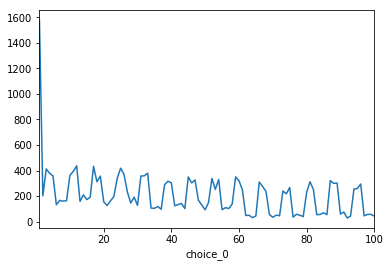

In [331]:
family_data.groupby(['choice_0']).sum()['n_people'].plot()

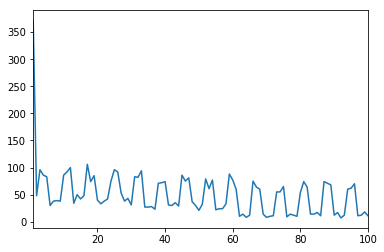

In [332]:
family_data['choice_0'].value_counts().sort_index().plot()

# Globals

In [333]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

days = list(range(N_DAYS, 0, -1))
choice_dict = family_data[[f'choice_{i}' for i in range(10)]].to_dict()
family_size_dict = family_data[['n_people']].to_dict()['n_people']

OUT_PATH = './submission.csv'
submission = pd.read_csv(OUT_PATH, index_col='family_id')

# Cost Function

In [334]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [335]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)
print(start_score)

new = best.copy()
# loop over each family

i=0

for fam_id, _ in enumerate(best):
    i+=1
    if i%500==0:
        print(i)
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)
            print(start_score)
            
submission['assigned_day'] = new
score = cost_function(new)
print(score)
submission.to_csv(f'submission_{score}.csv')
submission.to_csv(f'submission.csv')
print(f'Score: {score}')
            

73529.16190007067
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
73529.16190007067
Score: 73529.16190007067


# Pytorch Approach

In [336]:
import numpy as np
import pandas as pd
from pathlib import Path
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numba import njit
MAX_CHOICE=5


In [337]:
root_path = './santa-workshop-tour-2019/'
best_submit_path='./'

In [338]:
fpath = root_path + 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = root_path + 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [339]:
dummies = []
for i in range(MAX_CHOICE):
    dummies.append((pd.get_dummies(data[f'choice_{i}']).values*data['n_people'].values.astype(np.int8).reshape(-1,1)).reshape(5000, 100, 1))
dummies = np.concatenate(dummies, axis=2)
dummies = np.swapaxes(dummies, 1, 2)

penalties = {n: [0, 50, 50 + 9 * n, 100 + 9 * n, 200 + 9 * n, 200 + 18 * n, 300 + 18 * n, 300 + 36 * n, 400 + 36 * n, 500 + 36 * n + 199 * n] for n in np.unique(data['n_people'])}

mat = []
for i in range(5000):
    n = data.iloc[i]['n_people']
    mat.append(penalties[n][:MAX_CHOICE])
mat = np.array(mat)

initial_sub = pd.read_csv(best_submit_path+'submission.csv')
fam_choices = data
a = pd.merge(initial_sub, fam_choices, on='family_id')
    
initial_choices = []
for i in range(MAX_CHOICE):
    initial_choices.append(((a[f'choice_{i}'] == a['assigned_day'])).values.reshape(-1,1))
initial_choices = np.concatenate(initial_choices, axis=1)
initial_choices = torch.tensor(
   initial_choices*10
    , dtype=torch.float32)#.cuda()

In [340]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

family_size_ls = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
    n: [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(max(family_size_dict.values())+1)
} 

def cost_function(prediction):
    penalty = 0
    violations = 0
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, d, choice in zip(family_size_ls, prediction, choice_dict_num):
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            violations += 1
#             penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    return penalty, accounting_cost, violations

In [341]:
cost_function(initial_sub['assigned_day'].values)

(68388, 5141.161900070668, 0)

In [342]:
class Model(nn.Module):
    def __init__(self, mat, dummies):
        super().__init__()
        self.mat = torch.from_numpy(mat).type(torch.float32)#.cuda()
        self.dummies = torch.from_numpy(dummies).type(torch.float32)#.cuda()
        self.weight = torch.nn.Parameter(data=torch.Tensor(5000, MAX_CHOICE)#.cuda()
                                         , requires_grad=True)
        self.weight.data.copy_(initial_choices)
        
    def forward(self):
        prob = F.softmax(self.weight,dim=1)
        
        x = (prob * self.mat).sum()
        
        daily_occupancy = torch.zeros(100, dtype=torch.float32)#.cuda()
        for i in range(5000):
            daily_occupancy += prob[i]@self.dummies[i]
        diff = torch.cat([torch.abs(daily_occupancy[:-1] - daily_occupancy[1:]), torch.Tensor([0])])
        y = ( torch.relu(daily_occupancy-125.0) / 400.0 * daily_occupancy**(0.5 + diff / 50.0)).sum() 
        
        v = (torch.relu(125-daily_occupancy)**2+torch.relu(daily_occupancy-300)**2).sum()
            
        return  x, y, v*10000

In [343]:
model = Model(mat, dummies)
best_score = 10e10
best_pos = None
optimizer = torch.optim.Adam(model.parameters(), lr = 1)

In [344]:
for epoch in tqdm.tqdm_notebook(range(500)):
    optimizer.zero_grad()
    x, y, v= model()
    loss = x + y + v
    loss.backward()
    optimizer.step()
    
    if epoch % 1 == 0:
        pos = model.weight.argmax(1).cpu().numpy()
        pred = []
        for i in range(5000):
            pred.append(data.iloc[i][f'choice_{pos[i]}'])
        pred = np.array(pred)
        a, b, v = cost_function(pred)
        score = a + b
        if (score < best_score) and v == 0:
            best_score = score
            best_pos = pred
            print(best_score)
            submission['assigned_day'] = best_pos
            submission.to_csv(f'submission.csv')

        x = np.round(x.item(),1)
        y = np.round(y.item(),1)
        print(f'{epoch}\t{x}\t{y}    \t{np.round(score)}   \t{a}\t{np.round(b)}\t{v}')

73529.16190007067
0	68489.1	5154.3    	73529.0   	68388	5141.0	0
1	68472.7	5400.9    	73529.0   	68388	5141.0	0
2	68492.9	5185.3    	73529.0   	68388	5141.0	0
3	68511.4	5150.8    	73529.0   	68388	5141.0	0
4	68497.2	5152.0    	73529.0   	68388	5141.0	0
5	68453.9	5150.9    	73529.0   	68388	5141.0	0
6	68402.0	5154.8    	73529.0   	68388	5141.0	0
7	68391.7	5149.8    	73529.0   	68388	5141.0	0
8	68363.8	5163.6    	73529.0   	68388	5141.0	0
9	68365.3	5155.1    	73529.0   	68388	5141.0	0
10	68393.0	5120.6    	73529.0   	68438	5091.0	0
11	68439.2	5063.6    	73612.0   	68334	5278.0	1
12	68386.5	5108.7    	73556.0   	68488	5068.0	0
13	68345.5	5142.5    	73563.0   	68538	5025.0	0
14	68312.9	5189.7    	73568.0   	68488	5080.0	0
15	68349.4	5141.2    	73581.0   	68334	5247.0	1
16	68398.0	5092.5    	73581.0   	68334	5247.0	1
17	68378.9	5109.7    	73581.0   	68334	5247.0	1
18	68409.7	5072.9    	73566.0   	68248	5318.0	1
19	68483.5	5000.3    	73616.0   	68275	5341.0	1
20	68452.5	5027.2    	73598.0   

169	68370.5	5090.9    	73608.0   	68298	5310.0	1
170	68369.2	5092.2    	73558.0   	68520	5038.0	0
171	68365.4	5095.7    	73558.0   	68520	5038.0	0
172	68369.8	5091.4    	73608.0   	68298	5310.0	1
173	68367.1	5094.1    	73608.0   	68298	5310.0	1
174	68361.6	5099.6    	73608.0   	68298	5310.0	1
175	68360.6	5100.9    	73608.0   	68298	5310.0	1
176	68373.5	5087.7    	73608.0   	68298	5310.0	1
177	68371.0	5090.5    	73608.0   	68298	5310.0	1
178	68362.2	5099.1    	73558.0   	68520	5038.0	0
179	68369.6	5091.9    	73608.0   	68298	5310.0	1
180	68373.1	5088.1    	73608.0   	68298	5310.0	1
181	68369.1	5092.5    	73608.0   	68298	5310.0	1
182	68361.8	5099.4    	73558.0   	68520	5038.0	0
183	68368.0	5093.6    	73558.0   	68520	5038.0	0
184	68370.3	5090.9    	73608.0   	68298	5310.0	1
185	68366.7	5095.0    	73608.0   	68298	5310.0	1
186	68370.8	5090.5    	73608.0   	68298	5310.0	1
187	68370.8	5090.7    	73608.0   	68298	5310.0	1
188	68367.1	5094.2    	73608.0   	68298	5310.0	1
189	68366.8	5094.8  

336	68358.3	5102.2    	73608.0   	68298	5310.0	1
337	68356.9	5103.6    	73608.0   	68298	5310.0	1
338	68364.1	5096.2    	73608.0   	68298	5310.0	1
339	68365.2	5095.2    	73608.0   	68298	5310.0	1
340	68358.4	5102.1    	73608.0   	68298	5310.0	1
341	68353.3	5107.0    	73608.0   	68298	5310.0	1
342	68359.9	5100.6    	73608.0   	68298	5310.0	1
343	68350.0	5110.4    	73608.0   	68298	5310.0	1
344	68372.9	5087.6    	73608.0   	68298	5310.0	1
345	68349.7	5110.8    	73558.0   	68520	5038.0	0
346	68360.6	5100.1    	73608.0   	68298	5310.0	1
347	68345.6	5115.2    	73557.0   	68570	4987.0	0
348	68366.9	5094.0    	73608.0   	68298	5310.0	1
349	68339.7	5120.9    	73608.0   	68298	5310.0	1
350	68367.5	5093.2    	73608.0   	68298	5310.0	1
351	68351.7	5109.1    	73608.0   	68298	5310.0	1
352	68357.1	5103.6    	73608.0   	68298	5310.0	1
353	68371.7	5089.0    	73608.0   	68298	5310.0	1
354	68354.8	5105.9    	73608.0   	68298	5310.0	1
355	68358.7	5102.3    	73607.0   	68348	5259.0	1
356	68370.9	5090.1  